In [4]:
import torch
from torch import nn, optim
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple
import pandas as pd
import os
import cv2

# Define all constants
MEAN = (0.2906, 0.3271, 0.3252)
STD = (0.7984, 0.8028, 0.7954)
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 64
NUM_EPOCHS = 25
NUM_CLASSES = 100
BEST_MODEL_PATH = 'best_model.pth'

c:\Users\Shanna\miniconda3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [222]:
class AlbumentationsTransform:
  """A class to make Albumentations compatible with built-in torchvision Datasets.

  This class takes an Albumentations transformation as input and makes it
  behaive astorchvision Transform objects. Note that if you are using your own
  dataset, this is not needed.

  Attributes:
    transform: An Albumentations transform object.

    """
  def __init__(self, transform):
    """Initializes AlbumentationsTransform with a given PyTorch transform.

    Args:
      transform: An Albumentations transform object.
    """
    self.transform = transform

  def __call__(self, img):
    img = np.array(img)
    augmented = self.transform(image=img)
    img = augmented['image']
    return img

In [223]:
class CarClassification(Dataset):
    def __init__(self, root, csv, transforms=None):
        self.root = root
        self.transforms = transforms
        self.data_frame = pd.read_csv(csv)
        
        self.ids = self.data_frame['id'].tolist()
        # Extract image paths and labels from the CSV
        self.images = [os.path.join(root, img_path) for img_path in self.data_frame['id']]

        self.labels = self.data_frame['label'].tolist()
        # Get unique labels for class mapping
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.labels)
    
    def get_tensor_from_label(self, label):
        label_id = self.unique_labels.index(label)
        return torch.tensor(label_id)
    
    def __getitem__(self, i) -> Tuple[torch.Tensor, torch.Tensor]:
        image_path = self.images[i]
        label = self.labels[i]
        id = self.ids[i]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Apply any transformations if provided
        if self.transforms is not None:
            image = self.transforms(image)
    
        return image, self.get_tensor_from_label(label), id

In [224]:
def visualize_image_grid(image_label_id, rows, cols, mean=MEAN, std=STD):
  """
  Visualizes a grid of images with their labels.

  Args:
    image_label_pairs: A list of tuples, where each tuple is (image, label).
    rows: The number of rows where images are shown.
    cols: The number of columns where images are shown.
  """
  if len(image_label_id) != rows * cols:
    raise ValueError("The number of image-label pairs must exactly match rows * cols")
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
  for ax, (image, label, id) in zip(axes.flatten(), image_label_id):
    image = image.permute(1, 2, 0)
    image *= torch.Tensor(std)
    image += torch.Tensor(mean)
    ax.imshow(image)
    ax.set_title(f"{id}: class {label}")
    ax.axis('off')
  plt.tight_layout()
  plt.show()


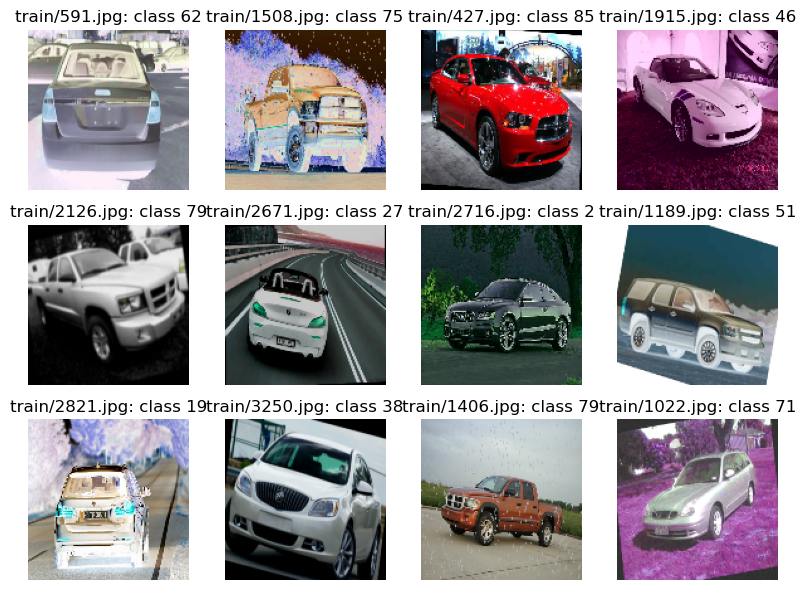

In [225]:
from albumentations.pytorch import ToTensorV2

# Define transforms for training data
train_transform = A.Compose(
    transforms=[
        A.Rotate(
            limit=(-15, 15),
            interpolation=1,
            border_mode=0,
            value=0,
            mask_value=0,
            always_apply=False,
            p=0.5,
        ),
        A.ColorJitter(
            brightness=0.3,
            contrast=0.4,
            saturation=0.6,
            hue=0.2,
            always_apply=False,
            p=0.5,
        ),
        A.InvertImg(p=0.1),
        A.ChannelShuffle(p=0.2),
        A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.2),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2
        ),
        A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=1, p=0.1),
        A.ToGray(p=0.1),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.1),
        A.GaussianBlur(blur_limit=(3, 7), p=0.1),
        A.MotionBlur(blur_limit=(3, 7), p=0.1),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=50, p=0.1),
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ],
    p=1.0,
)

# Prepare the transform
train_transform = AlbumentationsTransform(train_transform)

# Prepare training data
train_data = CarClassification(root="Dataset", csv="Dataset/train.csv", transforms=train_transform)

# Visualize training data
rows = 3
columns = 4
data = train_data
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)


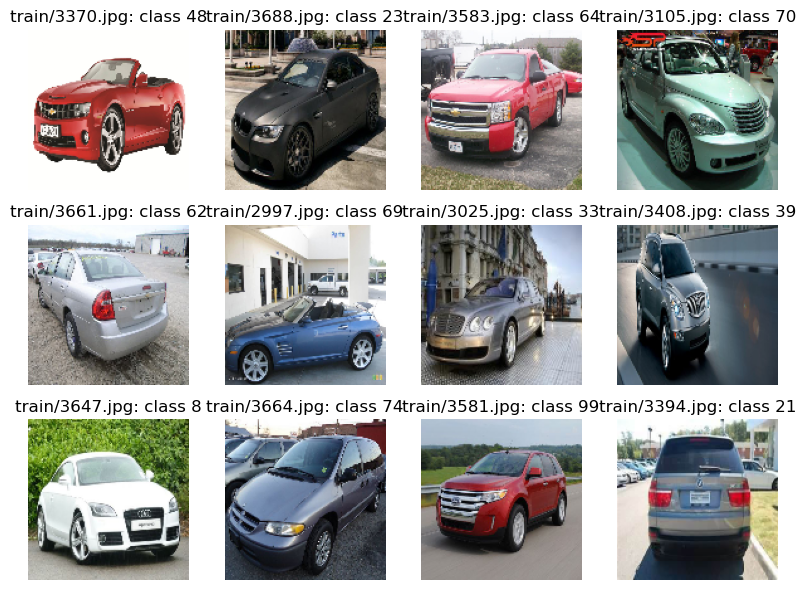

In [226]:
# Prepare validation data
valid_transform = A.Compose(
    transforms=[
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD, always_apply=True),
        ToTensorV2(),
    ],
    p=1.0,
)
valid_transform = AlbumentationsTransform(valid_transform)
valid_data = CarClassification(root="Dataset", csv="Dataset/valid.csv", transforms=valid_transform)

#Visualize test data
rows = 3
columns = 4
data = valid_data
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
valid_examples = [data[i] for i in indices]
visualize_image_grid(valid_examples, rows, columns)

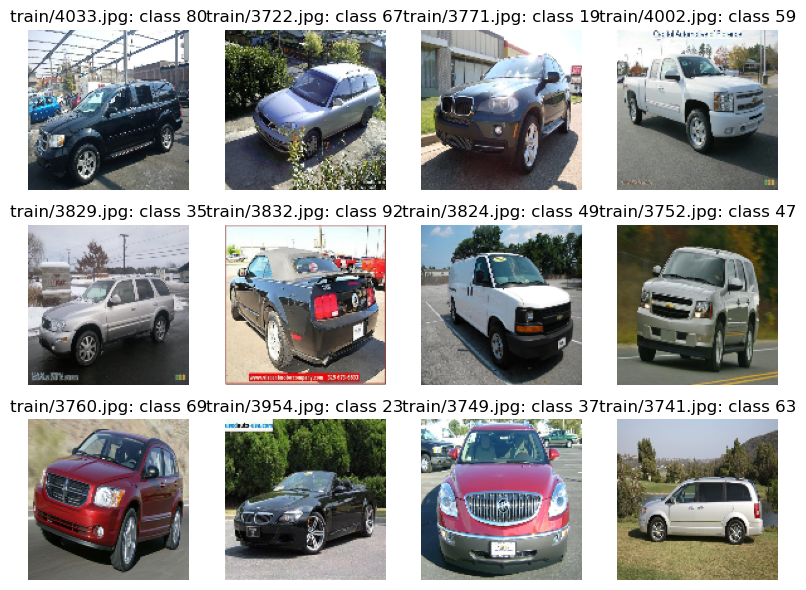

In [227]:
# Prepare validation data
test_transform = A.Compose(
    transforms=[
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD, always_apply=True),
        ToTensorV2(),
    ],
    p=1.0,
)
test_transform = AlbumentationsTransform(test_transform)
test_data = CarClassification(root="Dataset", csv="Dataset/test.csv", transforms=test_transform)

#Visualize test data
rows = 3
columns = 4
data = test_data
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
test_examples = [data[i] for i in indices]
visualize_image_grid(test_examples, rows, columns)

In [228]:
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

if torch.cuda.is_available():
    print("CUDA enabled")
else:
    print("CUDA not found")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

CUDA enabled


In [229]:
def freeze(model):
  for param in model.parameters():
    param.requires_grad = False

# unfreeze the parameters of the first layer
def unfreeze(model, layer):
  for param in model.features[layer].parameters():  # Adjust the slice as needed
    param.requires_grad = True

# model = models.resnet50(weights='IMAGENET1K_V2')
model = models.densenet121(weights=models.DenseNet121_Weights)
freeze(model)

model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
print(model)
# classifier = nn.Sequential(
#     nn.Linear(in_features=2048, out_features=NUM_CLASSES)
#     )
# model.fc = classifier
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
optimizer = optim.SGD(
    model.parameters(),  # Pass the model's parameters
    lr=0.001,             # Learning rate
    momentum=0.9,        # Momentum helps accelerate gradients
    weight_decay=1e-4    # Weight decay for L2 regularization (optional)
)

trainable_params = list(filter(lambda p: p.requires_grad, model.parameters()))
print(f"Number of trainable parameters: {len(trainable_params)}")


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

c:\Users\Shanna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 2


In [230]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  """Evaluate the performance of a model on a given dataset.

  This function calculates the loss and accuracy of the model on the dataset.
    It also returns the ground truth labels and the model's predictions.

  Args:
    model (torch.nn.Module): The model to be evaluated.
    loader (torch.utils.data.DataLoader): The data loader for the dataset.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    phase (str, optional): The phase of evaluation. Defaults to 'Valid'.

  Returns:
    dict: A dictionary containing the following keys:
      'loss' (float): The average loss of the model on the dataset.
      'accuracy' (float): The accuracy of the model on the dataset.
      'ground_truth' (list): The ground truth labels of the dataset.
      'predictions' (list): The model's predictions on the dataset.
    """
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels, id) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy= {accuracy:<10.4f}  Loss= {loss:<10.4f}')
    # print(f'groundtruth: {ground_truth}')
    # print(f'predictions: {predictions}')
    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions}

In [231]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  """Train a model and evaluate its performance on a validation set.

  This function trains a model for a specified number of epochs and evaluates
    its performance on a validation set after each epoch. The model with the
    lowest validation loss is saved.

  Args:
    model (torch.nn.Module): The model to be trained.
    train_loader (torch.utils.data.DataLoader): The data loader for the training set.
    valid_loader (torch.utils.data.DataLoader): The data loader for the validation set.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    optimizer (torch.optim.Optimizer): The optimization algorithm.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    epochs (int): The number of times the learning algorithm will work through the entire training dataset.
    best_model_path (str): The path where the best model will be saved.

  Returns:
    dict: A dictionary containing the 'loss', 'accuracy', 'ground_truth', and 'predictions'
            of the model with the lowest validation loss.
    """
  model.train()
  best_loss = torch.inf
  best_results = None
  best_accuracy = -torch.inf
  epoch_accuracy = []
  valid_accuracy = []
  unfreeze_layer = 0
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

  for epoch in range(epochs):
    trainable_params = list(filter(lambda p: p.requires_grad, model.parameters()))
    print(f"Number of trainable parameters: {len(trainable_params)}")
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Learning Rate: {scheduler.get_last_lr()[0]}')
    total_loss = 0
    total  = 0
    correct = 0

    for batch_index, (images, labels, id) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      if any(param.requires_grad for param in model.parameters()):
        loss.backward()
        optimizer.step()

      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()

    # Get Statistics
    # scheduler.step()  # Update learning rate at the end of each epoch
    accuracy = correct / total
    epoch_accuracy.append(accuracy)
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    valid_accuracy.append(results['accuracy'])
    if results['accuracy'] < (best_accuracy+0.04):
      unfreeze_layer -= 1
      if unfreeze_layer > -13:
        unfreeze(model, unfreeze_layer)
        print(f'Layer {unfreeze_layer} unfrozen')
    if results['loss'] < best_loss:
      torch.save(model, best_model_path)
      best_loss = results['loss']
      best_accuracy = results['accuracy']
      best_results = results
    print()
    scheduler.step(results['loss'])


  return best_results, epoch_accuracy, valid_accuracy

In [232]:
best_results, epoch_accuracy, valid_accuracy = training(model, train_loader, valid_loader, criterion,
                         optimizer, device, NUM_EPOCHS, BEST_MODEL_PATH)

Number of trainable parameters: 2
Epoch [1/25], Learning Rate: 0.001
0    Train Accuracy=0.0058      Loss= 4.7111    
     Valid Accuracy= 0.0151      Loss= 4.6085    

Number of trainable parameters: 2
Epoch [2/25], Learning Rate: 0.001
1    Train Accuracy=0.0215      Loss= 4.5782    
     Valid Accuracy= 0.0261      Loss= 4.4887    
Layer -1 unfrozen

Number of trainable parameters: 4
Epoch [3/25], Learning Rate: 0.001
2    Train Accuracy=0.0343      Loss= 4.4848    
     Valid Accuracy= 0.0481      Loss= 4.3697    
Layer -2 unfrozen

Number of trainable parameters: 100
Epoch [4/25], Learning Rate: 0.001
3    Train Accuracy=0.0600      Loss= 4.3144    
     Valid Accuracy= 0.1030      Loss= 3.9962    

Number of trainable parameters: 100
Epoch [5/25], Learning Rate: 0.001
4    Train Accuracy=0.1158      Loss= 3.9657    
     Valid Accuracy= 0.1731      Loss= 3.5403    

Number of trainable parameters: 100
Epoch [6/25], Learning Rate: 0.001
5    Train Accuracy=0.1752      Loss= 3.5550

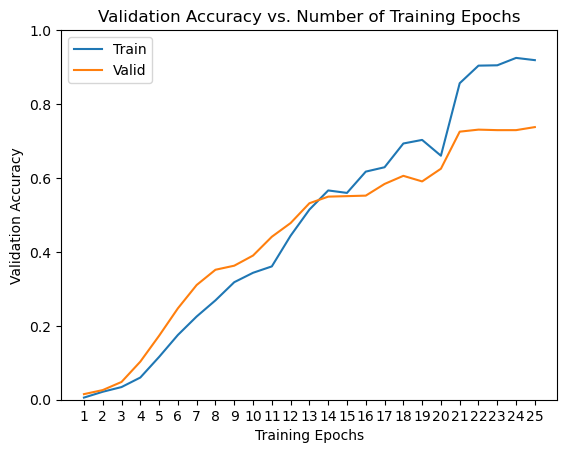

In [5]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from 

epoch_accuracy = [0.005759321006365566, 0.021521673234313428, 0.03425280387996363, 0.06001818732949379, 0.11579266444377084, 0.1752046074568051, 0.22521976356471657, 0.26886935434980297, 0.3179751439830252, 0.34343740527432554, 0.36071536829342227, 0.4437708396483783, 0.5143983025159139, 0.566232191573204, 0.5595635040921492, 0.6171567141558048, 0.6289784783267657, 0.6932403758714762, 0.7029402849348287, 0.6602000606244316, 0.8563200969990906, 0.903910275841164, 0.9048196423158533, 0.9248257047590179, 0.9187632615944226]
valid_accuracy = [0.01510989010989011, 0.0260989010989011, 0.04807692307692308, 0.10302197802197802, 0.17307692307692307, 0.24725274725274726, 0.31043956043956045, 0.3516483516483517, 0.3626373626373626, 0.3901098901098901, 0.4409340659340659, 0.47802197802197804, 0.5315934065934066, 0.5494505494505495, 0.5508241758241759, 0.5521978021978022, 0.5837912087912088, 0.6057692307692307, 0.5906593406593407, 0.625, 0.7252747252747253, 0.7307692307692307, 0.7293956043956044, 0.7293956043956044, 0.7376373626373627]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),epoch_accuracy,label="Train")
plt.plot(range(1,NUM_EPOCHS+1),valid_accuracy,label="Valid")
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

In [242]:
best_model = torch.load(BEST_MODEL_PATH)
results = evaluation(best_model, test_loader, criterion, device, 'Test')

C:\Users\Shanna\AppData\Local\Temp\ipykernel_3828\3449002606.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(BEST_MODEL_PATH)


     Test Accuracy= 0.0622      Loss= 13.8907   


In [219]:
def update_predictions(model, data_loader, device, csv_path):
    """
    Update the 'Expected' column in an existing CSV file with model predictions.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): The data loader for the dataset.
        device (torch.device): The device (CPU or GPU) where computations will be performed.
        csv_path (str): Path to the CSV containing image IDs and 'Expected' column to be updated.

    Returns:
        None
    """
    # Load the existing CSV into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Create a dictionary to store predictions: {image_id: prediction}
    predictions_dict = {}
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, image_labels, image_ids in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            # Store predictions in the dictionary
            for img_id, pred in zip(image_ids, preds.cpu().numpy()):
                predictions_dict[img_id] = pred

    # Ensure unique IDs in the DataFrame (if duplicates are unexpected)
    df = df.drop_duplicates(subset=['id'])
    print(predictions_dict)
    # Update the 'Expected' column in the DataFrame with the predictions
    df['label'] = df['id'].map(predictions_dict)
    
    # Save the updated DataFrame back to the same CSV or to a new one
    df.to_csv(csv_path, index=False)
    print(f"Updated predictions saved to {csv_path}")

In [241]:
# Prepare training data
eval_data = CarClassification(root="Dataset", csv="Dataset/Solution.csv", transforms=valid_transform)
eval_loader = DataLoader(eval_data, BATCH_SIZE, shuffle=False)

best_model = torch.load(BEST_MODEL_PATH)
results = update_predictions(best_model, eval_loader, device, "Dataset/Solution.csv")

C:\Users\Shanna\AppData\Local\Temp\ipykernel_3828\2252645850.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(BEST_MODEL_PATH)


{'test/NSklfSDmid.jpg': 38, 'test/mLVggEcQSs.jpg': 58, 'test/dNklPsHZdF.jpg': 5, 'test/MvVlQPkRHo.jpg': 40, 'test/JoWwDAaAKP.jpg': 16, 'test/QPwWiJULSH.jpg': 59, 'test/snuFXqartX.jpg': 38, 'test/huRCadonqt.jpg': 39, 'test/gfwbhDXAIj.jpg': 92, 'test/twmrQQPcgM.jpg': 52, 'test/ruQYnFwzaa.jpg': 38, 'test/agbzWllQSo.jpg': 67, 'test/hGoKSLDxGI.jpg': 26, 'test/AxIkpNrQbg.jpg': 12, 'test/LrgllggwEm.jpg': 30, 'test/xVNfcoKLvy.jpg': 15, 'test/AixchHnvcs.jpg': 86, 'test/BhNpJkUzCq.jpg': 96, 'test/DhkggNXnyW.jpg': 98, 'test/FKpQUKBsXq.jpg': 91, 'test/WVPpBMkEAE.jpg': 52, 'test/oxHAsoaAMV.jpg': 21, 'test/DVzCiIUkJW.jpg': 71, 'test/YPSChyggSV.jpg': 13, 'test/hbEndIgzuW.jpg': 13, 'test/eNmlZHpOGE.jpg': 0, 'test/PaNtykwJnG.jpg': 77, 'test/aYegPidJCa.jpg': 65, 'test/mZfsPHgKqt.jpg': 0, 'test/eGkXNCenOP.jpg': 57, 'test/IIdtGhpQLP.jpg': 97, 'test/xusMkpJFFz.jpg': 92, 'test/xZJytpbEqv.jpg': 1, 'test/QWGRfGgJIX.jpg': 83, 'test/LSQKYEEkHc.jpg': 40, 'test/oqmpZVhqWD.jpg': 50, 'test/DCJlnjTayt.jpg': 52, 'tes